In [1]:
import numpy as np
from time import time
from lloyd_utils import lloyd_update, calc_sq_distances, calc_sizes
from kernel_utils import kernel_matrix
from quality_utils import calc_silhouettes
from elkan_utils import update_elkan
start_elkan = lloyd_update #TODO 

In [2]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=3,
                 max_iter=300, tol=0, q_metric="inertia", verbose=False,
                 seed=None, algorithm="lloyd", kernel="linear", **kwargs):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.q_metric = q_metric
        self.verbose = verbose
        self.rng = np.random.default_rng(seed)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwargs = kwargs
        self.labels = None
        self.inner_sums = np.zeros(n_clusters, dtype=np.int_)
        self.cluster_sizes = None
        self.trained_data = None
        self.quality = None
    
    def kernel_wrapper(self, X, Y=None):
        return kernel_matrix(X, Y, kernel=self.kernel, **self.kwargs)

    def fit(self, X):
        
        X = self._sanitize_data(X)
        self._check_params(X)
        kernel_matrix = self.kernel_wrapper(X)
        
        labels_store = np.zeros((self.n_init, X.shape[0]), dtype=np.int_)
        quality_store = np.zeros(self.n_init)
        inner_sums_store = np.zeros((self.n_init, self.n_clusters))
        sizes_store = np.zeros((self.n_init, self.n_clusters), dtype=np.int_)
        
        for init in range(self.n_init):
            start_labels = self._init_labels(X, kernel_matrix)
            if self.algorithm == "lloyd":
                labels, quality, inner_sums, sizes = self._lloyd(kernel_matrix, start_labels)
            elif self.algorithm == "elkan":
                labels, quality, inner_sums, sizes = self._elkan(kernel_matrix, start_labels)
            else:
                raise ValueError(self.algorithm + " algorithm not implemented")
            labels_store[init] = labels
            quality_store[init] = quality
            inner_sums_store[init] = inner_sums
            sizes_store[init] = sizes

        best_init = self._get_best_init(quality_store)
        self.labels = labels_store[best_init]
        self.inner_sums = inner_sums_store[best_init]
        self.cluster_sizes = sizes_store[best_init]
        self.quality = quality_store[best_init]
        self.trained_data = X
        
        if self.verbose:
            print("Best " + self.q_metric +":", self.quality,
                "Found at init:", best_init + 1)

    def _check_params(self, data):
        if self.algorithm == "elkan" and self.q_metric == "silhouette":
            print("WARNING: using silhouette as metric with elkan will most likely be inaccurate\
                  as elkan  does not calculate exact distances to every center")
        if self.n_init <= 0:
            raise ValueError("n_inits needs to be at least 1")

        if data.shape[0] <  self.n_clusters:
            raise ValueError("sample:cluster ratio needs to be at least one")
        


        
    def _get_best_init(self, quality_store):
        if self.q_metric == "inertia":
            return np.argmin(quality_store)
        elif self.q_metric == "silhouette":
            return np.argmax(quality_store)
        else:
            raise Exception("Quality metric not implemented. This should never occur.")


    def _sanitize_data(self, X):
        X = np.asarray(X, dtype=np.double)
        if len(X.shape) != 2:
            raise ValueError("X needs to be 2-d Array")
        if 0 in X.shape:
            raise ValueError("X is empty")
        return X
    
    def _init_labels(self, X, kernel_matrix):
        '''Assign labels to each datapoint by given method'''
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self.init = self._sanitize_centers() 
            return self._assign_to_centers(X, self.init)
        
        elif self.init == "random":
            centers = self.rng.choice(X, self.n_clusters)
            return self._assign_to_centers(X, centers)
        elif self.init == "truerandom":
            return self.rng.integers(0, self.n_clusters, len(X))
        
        elif self.init == "kmeans++":
            return self._kmeanspp(X, kernel_matrix)
        
        raise NotImplementedError("Unknown initialisation method")
    
    def _sanitize_centers(self, centers):
        centers = np.asarray(centers, dtype=np.float64)
        if len(centers.shape) != 2:
            raise ValueError("Given centers need to be 2-d array")
        if 0 in centers.shape:
            raise ValueError("Given centers are empty")
        if len(centers) != self.n_clusters:
            raise ValueError("Amount of given centers must be equal to n_clusters")
        return centers
        
    def _assign_to_centers(self, X, centers):
        X_center_kernel = self.kernel_wrapper(X, centers)
        dists_to_centers = np.zeros((len(X), self.n_clusters))
        for cluster in range(self.n_clusters):
            dists_to_centers[:, cluster] = (-2 * X_center_kernel[:, cluster]
                             + self.kernel_wrapper(centers[cluster]))
        return np.argmin(dists_to_centers, axis=1)

    def _kmeanspp(self, X, kernel_matrix):
        dists_to_centers = self._build_starting_distance(kernel_matrix)
        data_size = X.shape[0]
        for cluster in range(self.n_clusters):
            if cluster == 0:
                index = self.rng.integers(low=0, high=data_size)
            else:
                max_dist_each = np.amin(dists_to_centers[:, :cluster + 1], axis = 1)
                #max_dist_each[max_dist_each < 0] = 0 # TODO test if really necessary
                probs = max_dist_each/max_dist_each.sum()
                index = self.rng.choice(len(X), size=1, p=probs)
            center = X[index]
            inner_sum = self.kernel_wrapper(center)
            outer_sum = self.kernel_wrapper(X, center)
            # reshape necessary as kernel_wrapper has 2dim array output
            dists_to_centers[:, cluster] += (-2 * outer_sum + inner_sum).reshape(data_size,) 
        
        #TODO SQRT!! dists_to_centers = sqrt(dists_to_centers)
            
        return np.argmin(dists_to_centers, axis=1)

    def _lloyd(self, kernel_matrix, labels):
        quality = 0
        for it in range(self.max_iter):
            distances = self._build_starting_distance(kernel_matrix)
            distances, inner_sums, cluster_sizes =\
                    lloyd_update(distances, kernel_matrix, labels, self.n_clusters)
            labels_old = labels
            labels = np.argmin(distances, axis=1)
            
            quality, converged = self.measure_iter(distances, labels, labels_old, quality)
            self._out_verbose(it, quality, converged=converged)
            if converged:
                break
        
        return labels, quality, inner_sums, cluster_sizes
    


    def _out_verbose(self, iter, quality, converged):
        if not self.verbose:
            return
        if converged:
            print("Converged at iteration:", iter + 1, self.q_metric + ":", quality)
        elif self.tol == 0:
            print("Iteration:", iter + 1, self.q_metric + ":", "Not calculated (Tol==0)")
        else:
            print("Iteration:", iter + 1, self.q_metric + ":", quality)
    
    def predict(self, X):
        kernel_matrix = self.kernel_wrapper(X, self.trained_data)
        sq_distances = calc_sq_distances(self.inner_sums, 
                                  self.cluster_sizes,
                                  kernel_matrix,
                                  self.labels, 
                                  self.n_clusters)
        return np.argmin(np.sqrt(sq_distances), axis=1)
    
    def measure_iter(self, sq_distances, labels, labels_old, quality):
        converged = False
        if self.tol != 0:
            quality_old = quality
            quality = self._calc_q_metric(sq_distances, labels)
            if abs(quality - quality_old) <= self.tol:
                converged = True

        if all(labels_old == labels):
            if self.tol == 0:
                quality = self._calc_q_metric(sq_distances, labels)
            converged = True
        
        return quality, converged

    def _calc_q_metric(self, sq_distances, labels):
        if self.q_metric == "inertia":
            return sq_distances[range(sq_distances.shape[0]), labels].sum()
        elif self.q_metric == "silhouette":
            return self.calc_silhouette(sq_distances, labels)
        else:
            raise NotImplementedError(str(self.q_metric) + " quality metric not implemented")
            
    def calc_silhouette(self, sq_distances, labels):
        dists = np.sqrt(sq_distances)
        silhouettes = calc_silhouettes(dists, labels)
        return sum(silhouettes) / len(silhouettes)
    
    def _build_starting_distance(self, kernel_matrix):
        return np.ascontiguousarray(np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T, dtype=np.double)

    def _elkan(self, kernel_matrix, labels):
        labels = np.array(labels, dtype=np.int_) # TODO delete and change dtype in init_labels
        start_dists = self._build_starting_distance(kernel_matrix)
        center_dists = np.zeros((kernel_matrix.shape[0], self.n_clusters))
        quality = 0
        for it in range(self.max_iter):
            if it == 0:
                l_bounds, inner_sums, sizes = start_elkan(start_dists, kernel_matrix, labels, self.n_clusters)
            else:
                l_bounds, inner_sums, sizes, center_dists = update_elkan(kernel_matrix, l_bounds, center_dists, labels, labels_old, sizes, inner_sums, self.n_clusters)

            labels_old = labels
            labels = np.array(np.argmin(l_bounds, axis=1), dtype=np.int_)
            
            quality, converged = self.measure_iter(l_bounds, labels, labels_old, quality)
            self._out_verbose(it, quality, converged=converged)
            if converged:
                break

        return labels, quality, inner_sums, sizes



In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [4]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [5]:
x, labels, centers = make_blobs(20, centers=10, return_centers = True, random_state = 1, n_features = 2)

In [6]:
kkme = KKMeans(n_clusters = 10, verbose = True, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia", n_init=3, tol = 0, algorithm="elkan")
kkml = KKMeans(n_clusters = 10, verbose = True, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia", n_init=3, tol = 1e-4, algorithm="lloyd")

In [7]:
kkme.fit(x)
kkml.fit(x)
print(kkme.quality)
print(kkml.quality)

Converged at iteration: 1 inertia: 11.782648282479279
Converged at iteration: 1 inertia: 9.508326004580043
Iteration: 1 inertia: Not calculated (Tol==0)
Converged at iteration: 2 inertia: 11.735052470803227
Best inertia: 9.508326004580043 Found at init: 2
Converged at iteration: 1 inertia: 11.782648282479279
Converged at iteration: 1 inertia: 9.508326004580043
Iteration: 1 inertia: 12.099125645536942
Converged at iteration: 2 inertia: 11.735052470803227
Best inertia: 9.508326004580043 Found at init: 2
9.508326004580043
9.508326004580043


In [14]:
# 10,5,30
#5, 2, 0&3
#20, 3, 63
size = 5
n_c= 2
for i in range(100):
    x, labels, centers = make_blobs(size, centers=n_c, return_centers = True, random_state = i, n_features = 2)
    kkme = KKMeans(n_clusters = n_c, verbose = False, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia", n_init=3, tol = 1e-4, algorithm="elkan")
    kkml = KKMeans(n_clusters = n_c, verbose = False, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia", n_init=3, tol = 1e-4, algorithm="lloyd")
    kkme.fit(x)
    kkml.fit(x)
    if not np.isclose(kkml.quality, kkme.quality):
        print(kkme.quality)
        print(kkml.quality)
        print(i)    


3.304808692146519
3.6611212981133896
0
3.379891648761358
4.093200803173389
4
2.417127108828687
3.0066163084693267
18
3.909548198681648
5.4749757055654555
19
3.2850299314805653
6.811862472315568
20
3.304371450466114
7.942030335005981
23
4.58058339382081
10.23827036149028
40
3.213470169881006
5.992035528488202
43
5.232865682256307
7.939994154014546
50
6.091854902295395
8.099404846573037
56
2.264940933714289
4.493234391245085
67
5.782019668643773
8.178135921527161
81
6.701066958384732
8.23929807761839
88
7.628924491843781
9.341648767399013
93


In [9]:
from sklearn.metrics import silhouette_score

In [10]:
print(silhouette_score(kkme.trained_data, kkme.labels))
print(silhouette_score(kkml.trained_data, kkml.labels))

0.3364309186092622
0.3391426865307079


0.02960968017578125


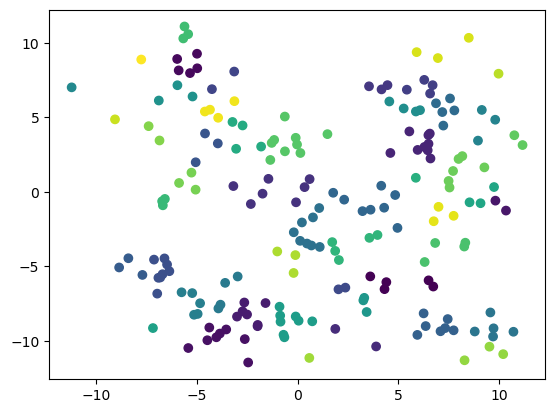

In [11]:
start = time()
kkml.fit(x)
end = time()
print(end - start)
visualize(x, kkml.labels)

In [12]:
Bestinertia: 5903.795041513802 Found at init: 1
3.8494319915771484

SyntaxError: invalid syntax (3434595123.py, line 1)

In [ ]:
km = KMeans(n_clusters = 20, verbose=True)
km.fit(x)

Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: center shift 0.0 within tolerance 0.0012087702229255921.
Initialization complete
Iteration 0, inertia 0.0
Converged at iteration 0: c

KMeans(n_clusters=20, verbose=True)

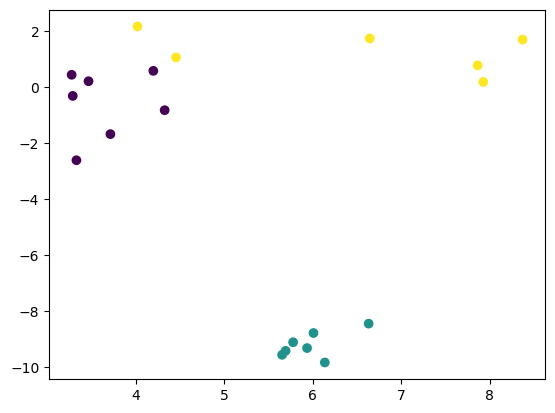

In [ ]:
visualize(x, labels)

In [ ]:
x, l = make_circles(7000, factor = 0.4, random_state=0)

In [ ]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "rbf", seed = 0, tol = 1e-4, variance=0.4, n_init = 5, q_metric="inertia", algorithm="lloyd")

Iteration: 1 inertia: 5721.08668223796
Iteration: 2 inertia: 5688.312870387039
Iteration: 3 inertia: 5673.176435318648
Iteration: 4 inertia: 5666.3738952592375
Iteration: 5 inertia: 5663.223801579773
Iteration: 6 inertia: 5661.71321370107
Iteration: 7 inertia: 5660.984263379243
Iteration: 8 inertia: 5660.623614000252
Iteration: 9 inertia: 5660.436267490713
Iteration: 10 inertia: 5660.324088379262
Iteration: 11 inertia: 5660.247685314462
Iteration: 12 inertia: 5660.186245705254
Iteration: 13 inertia: 5660.136644953051
Iteration: 14 inertia: 5660.087543634509
Iteration: 15 inertia: 5660.040183376219
Iteration: 16 inertia: 5659.9915243091755
Iteration: 17 inertia: 5659.928674685842
Iteration: 18 inertia: 5659.864064800108
Iteration: 19 inertia: 5659.796697289603
Iteration: 20 inertia: 5659.726446453123
Iteration: 21 inertia: 5659.637630126491
Iteration: 22 inertia: 5659.544432902676
Iteration: 23 inertia: 5659.446590402955
Iteration: 24 inertia: 5659.3423882035195
Iteration: 25 inertia: 5

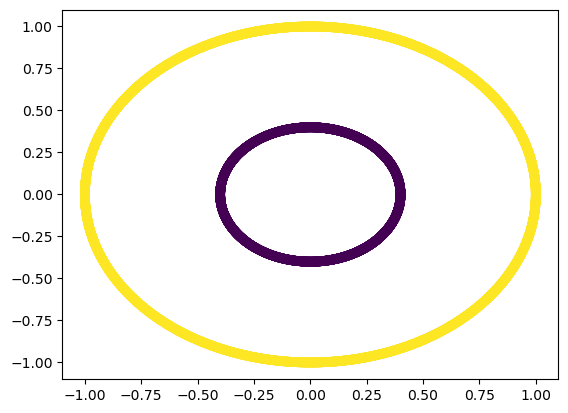

In [ ]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

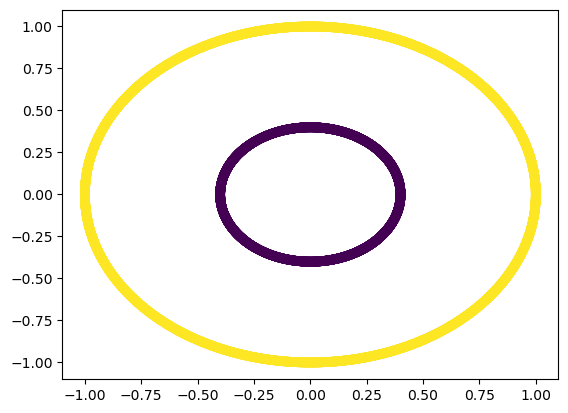

In [ ]:
visualize(x, kkm.predict(x))

In [ ]:
all(kkm.predict(x) == kkm.labels)

True